In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
from utils.helpers import pickle_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color2 = 'tomato'
color3 = '#222E50'
alpha = 0.9
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [2]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [3]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

In [4]:
KEYS = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns',
        'm1', 'm2', 'm3', 'm4',
        'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
        'a_ia', 'eta',
        'b1', 'b2', 'b3', 'b4', 'b5', 
        'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

In [5]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    if fname is not None:
        os.makedirs('plots', exist_ok=True)
        plt.savefig(f'plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    plt.close()

In [6]:
def process_chain_cobaya(engine = 'jaxcosmo', cov = True):
    record_samples = []
    for i in range(2):
        if cov:
            samples = np.loadtxt(f'outputcobaya/withcov/{engine}_{i+1}/des.1.txt')
        else:
            samples = np.loadtxt(f'outputcobaya/testing/{engine}_{i+1}/output_prefix.1.txt')
        record_samples.append(samples[:,2:-4])
    return record_samples

### Emulator Samples - NUTS

In [7]:
emulator_nuts = pickle_load('samples', 'emulator_nuts_small_ss_high_td')
emulator_samples_nuts = np.asarray([np.asarray(emulator_nuts.get_samples()[key]) for key in KEYS]).T

### Emulator Samples - Cobaya

In [8]:
emulator_samples_cobaya_list = process_chain_cobaya(engine = 'emulator', cov = True)
emulator_samples_cobaya = np.concatenate(emulator_samples_cobaya_list)

### JAX-COSMO Samples - NUTS

In [9]:
jaxcosmo_nuts = pickle_load('samples', 'jaxcosmo_nuts_small_ss_high_td')
jaxcosmo_samples_nuts = np.asarray([np.asarray(jaxcosmo_nuts.get_samples()[key]) for key in KEYS]).T

### JAX-COSMO Samples - Cobaya

In [10]:
jaxcosmo_samples_cobaya_list = process_chain_cobaya(engine = 'jaxcosmo', cov = True)
jaxcosmo_samples_cobaya = np.concatenate(jaxcosmo_samples_cobaya_list)

## Plots

In [11]:
# mcmc_samples_1 = jaxcosmo_samples_cobaya[:,0:5]  
# mcmc_samples_2 = jaxcosmo_samples_nuts[:,0:5] 

mcmc_samples_1 = emulator_samples_cobaya[:,0:5]
mcmc_samples_2 = emulator_samples_nuts[:,0:5] 

label_1 = 'Emulator and Cobaya' # 'EH and Cobaya'
label_2 = 'Emulator and NUTS' # 'EH and NUTS'

In [12]:
ndim = len(labels_cosmo)
names = ["x%s"%i for i in range(ndim)]

samples_1 = MCSamples(samples=mcmc_samples_1,names = names, labels = labels_cosmo, settings = settings, label = label_1)
samples_2 = MCSamples(samples=mcmc_samples_2,names = names, labels = labels_cosmo, settings = settings, label = label_2)

Removed no burn in
Removed no burn in


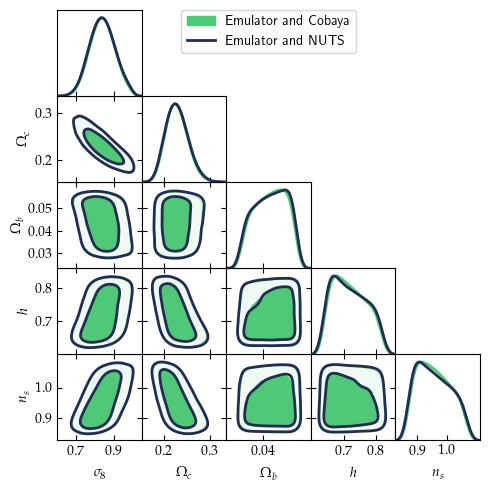

In [14]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contoburs': [0.68, 0.95]})
# G.triangle_plot([samples_1, samples_2, samples_3], filled = [True,False, False], contour_colors=[color1, color2, color3], contour_lws=[2, 2, 3], contour_ls=['-', '-', '--'])
G.triangle_plot([samples_1, samples_2], 
                filled = [True, False], 
                contour_colors=[color1, color3], 
                contour_lws=[2, 2], 
                contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# LSST Data

In [7]:
LSST_KEYS = ['sigma8', 'Omegac', 'Omegab', 'hubble', 'ns', "m1", "m2", "m3", "m4", "m5",
    "dz_wl_1", "dz_wl_2", "dz_wl_3", "dz_wl_4", "dz_wl_5",
    "a_ia", "eta", "b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10",
    "dz_gc_1", "dz_gc_2", "dz_gc_3", "dz_gc_4", "dz_gc_5",
    "dz_gc_6", "dz_gc_7", "dz_gc_8", "dz_gc_9", "dz_gc_10"]

In [8]:
def numpyro_model():
    pass

In [9]:
def lsst_cobaya_samples(engine = 'emulator', burnin = 0.1, cov = False):
    if cov:
        fname1 = f'CobayaLSST/{engine}_cov_1/lsst.1.txt'
        fname2 = f'CobayaLSST/{engine}_cov_2/lsst.1.txt'
    else:
        fname1 = f'CobayaLSST/{engine}_1/lsst.1.txt'
        fname2 = f'CobayaLSST/{engine}_2/lsst.1.txt'       
    samples_1 = np.loadtxt(fname1)[:,2:-4]
    samples_2 = np.loadtxt(fname2)[:,2:-4]
    start_1 = int(burnin * samples_1.shape[0])
    start_2 = int(burnin * samples_2.shape[0])
    return np.concatenate([samples_1[start_1:], samples_2[start_2:]])

In [10]:
def lsst_nuts_samples(engine = 'emulator'):
    if engine == 'emulator':
        sampler = pickle_load('lsst', f'nuts_sampler_{engine}')
        samples = np.vstack([sampler.get_samples()[key].tolist() for key in LSST_KEYS]).T
    else:
        samples = pickle_load('lsst', 'nuts_jaxcosmo_samples')
    return samples

In [11]:
lsst_cb_samples_em = lsst_cobaya_samples('emulator', cov = True)
lsst_cb_samples_eh = lsst_cobaya_samples('jaxcosmo', cov = True)

lsst_nuts_samples_em = lsst_nuts_samples('emulator')
lsst_nuts_samples_eh = lsst_nuts_samples('jaxcosmo')

In [12]:
ndim = len(labels_cosmo)
names = ["x%s"%i for i in range(ndim)]

label_1 = 'Emulator and Cobaya'
label_2 = 'Emulator and NUTS'

samples_1 = MCSamples(samples=lsst_cb_samples_em[:,0:5],names = names, labels = labels_cosmo, settings = settings, label = label_1)
samples_2 = MCSamples(samples=lsst_nuts_samples_em[:,0:5],names = names, labels = labels_cosmo, settings = settings, label = label_2)

Removed no burn in
Removed no burn in


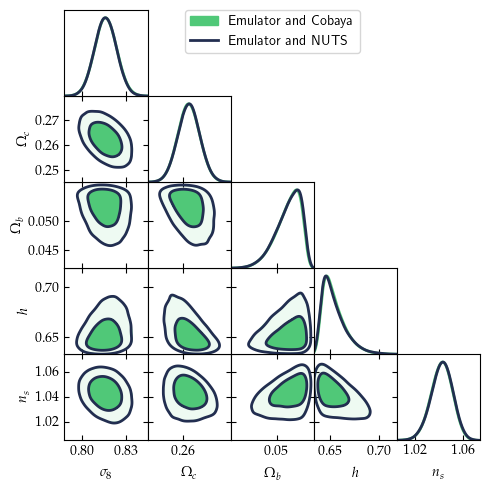

In [14]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contoburs': [0.68, 0.95]})
# samples_3.updateSettings({'contoburs': [0.68, 0.95]})
# G.triangle_plot([samples_1, samples_2, samples_3], filled = [True,False, False], contour_colors=[color1, color2, color3], contour_lws=[2, 2, 3], contour_ls=['-', '-', '--'])
G.triangle_plot([samples_1, samples_2], 
                filled = [True, False], 
                contour_colors=[color1, color3], 
                contour_lws=[2, 2], 
                contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison_lsst.pdf', transparent = False, bbox_inches = 'tight')  
plt.show()